# Conversion Rate Challenge : predict conversions

The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

## Part 1 : EDA

In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
!pip install plotly -q
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe_connected"
from IPython.display import display

In [2]:
# Read the file

print("Loading dataset...")
df = pd.read_csv("conversion_data_train.csv")
print("...Done.")
df.head()

Loading dataset...
...Done.


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
# Basics statistics

print("Number of rows : {}".format(df.shape[0]))
print()

print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
df_desc = df.describe(include='all')
display(df_desc)
print()

print("Percentage of missing values: ")
print()
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 284580

Number of columns : 6

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 



country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Conversion Distribution')

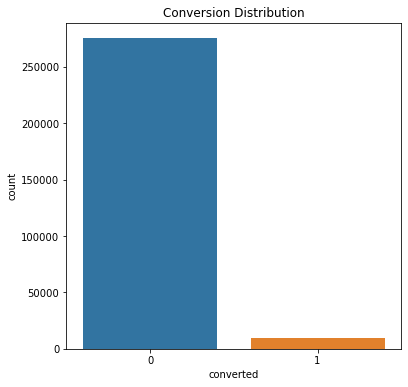

In [4]:
# Target distribution

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(df['converted'])
plt.title('Conversion Distribution')

In [5]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [6]:
# Distribution of each quantitative variable

num_features = ["age", "new_user", "total_pages_visited"]
fig1 = make_subplots(rows = len(num_features), cols = 1, subplot_titles = num_features)
for i in range(len(num_features)):
    fig1.add_trace(
        go.Histogram(
            x = df[num_features[i]], nbinsx = 30),
        row = i + 1,
        col = 1)
fig1.update_layout(
        title = go.layout.Title(text = "Distribution of quantitative variables", x = 0.5), showlegend = False, 
            autosize=True, height=2000)
fig1.show()

In [7]:
#df = df.convert_dtypes()
#df.dtypes

In [8]:
# Barplot of each qualitative variable

cat_features = ["country", "source"]
fig2 = make_subplots(rows = len(cat_features), cols = 1, subplot_titles = cat_features)
for i in range(len(cat_features)):
    
    x_coords = df[cat_features[i]].value_counts().index.tolist()
    y_coords = df[cat_features[i]].value_counts().tolist()
    
    fig2.add_trace(
        go.Bar(
            x = x_coords,
            y = y_coords),
        row = i + 1,
        col = 1)
fig2.update_layout(
        title = go.layout.Title(text = "Barplot of qualitative variables", x = 0.5), showlegend = False, 
            autosize=False, height=500)
fig2.show()

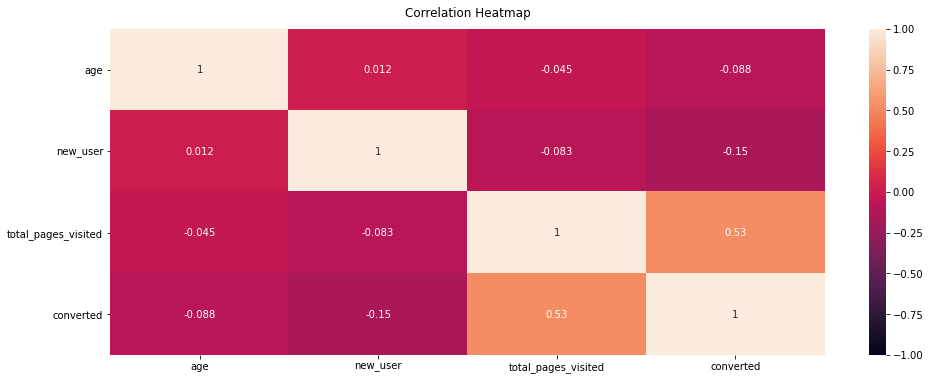

In [9]:
# Correlation matrix

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Part 2 : Data preprocessing and Baseline model (univariate logistic regression)

From the EDA, we know that the most useful feature is total_pages_visited. I create a baseline model by using at first only this feature 

In [10]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [11]:
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [12]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0,stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [13]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[2]
 [2]
 [7]
 [3]
 [8]]
[[14]
 [ 5]]

[0 0 0 0 0]
[0 0]


In [14]:
#Training pipeline
print("Encoding categorical features and standardizing numerical features...")
featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.85939501]
 [-0.85939501]
 [ 0.63639894]
 [-0.56023622]
 [ 0.93555773]]


In [15]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [16]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [17]:
#Test pipeline

print("Encoding categorical features and standardizing numerical features...")
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73051047]
 [ 0.03808136]
 [-0.26107743]
 [ 0.93555773]
 [-0.85939501]]


In [18]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1 0 0 ... 0 0 0]



In [19]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6971029668411867
f1-score on test set :  0.6771951989892608


Confusion matrix on train set : 
[[246790   1070]
 [  3269   4993]]



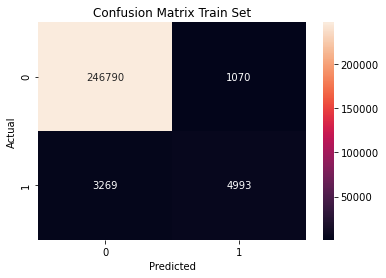

In [20]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

Confusion matrix on test set : 
[[27411   129]
 [  382   536]]



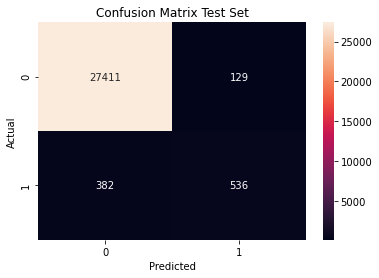

In [21]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [22]:
# Store result
univariate_lr_train = f1_score(Y_train, Y_train_pred)
print(univariate_lr_train)
univariate_lr_test = f1_score(Y_test, Y_test_pred)
print(univariate_lr_test)

0.6971029668411867
0.6771951989892608


## Part 3 : Data preprocessing and Multivariate logistic regression

The baseline model reaches a f1-score of almost 70%. Now, i refine the model with a multivariate regression to try to find a better model.

In [23]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


After using the forward selection method, it appears that it is not judicious to keep the "source" column. Consequently this one will no be kept for models.

In [24]:
# Separate target variable Y from features X

features_list = ['total_pages_visited','age','country','new_user']
numeric_indices = [0,1]
categorical_indices = [2,3]
target_variable = 'converted'

print("Separating labels from features...")
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]
print("...Done.")
print()
print('Explanatory variables : ', X.columns)
print()
print(X.head())
print()
print(Y.head())
print()

Separating labels from features...
...Done.

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user'], dtype='object')

   total_pages_visited  age  country  new_user
0                    2   22    China         1
1                    3   21       UK         1
2                   14   20  Germany         0
3                    3   23       US         1
4                    3   28       US         1

0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64



In [25]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [26]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print()
print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done

[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
[[14 24 'China' 1]
 [5 35 'US' 0]]

[0 0 0 0 0]
[0 0]


In [27]:
numeric_features = [0,1]
numeric_transformer = StandardScaler()

In [28]:
categorical_features = [2,3]
categorical_transformer = OneHotEncoder(drop='first')

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [30]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[[14 24 'China' 1]
 [5 35 'US' 0]
 [4 29 'US' 0]
 [8 31 'China' 1]
 [2 28 'US' 1]]
...Done.
[[ 2.73051047 -0.79365434  0.          0.          0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1. 

In [31]:
# Train model
print("Train model...")
classifier2 = LogisticRegression() 
classifier2.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [32]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier2.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [33]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier2.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [34]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7635487755921317
f1-score on test set :  0.7581620314389359


Confusion matrix on train set : 
[[246882    978]
 [  2556   5706]]



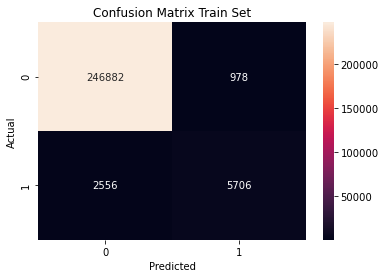

In [35]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()


Confusion matrix on test set : 
[[27431   109]
 [  291   627]]



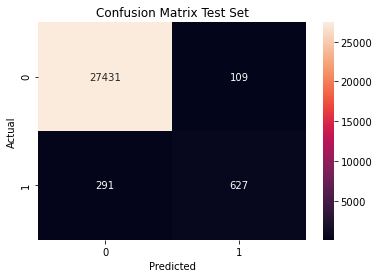

In [36]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [37]:
# Store result
multivariate_lr_train = f1_score(Y_train, Y_train_pred)
print(multivariate_lr_train)
multivariate_lr_test = f1_score(Y_test, Y_test_pred)
print(multivariate_lr_test)

0.7635487755921317
0.7581620314389359


## Part 4 : Data preprocessing and Decision Tree

The baseline model reaches a f1-score of almost 70% and the multivariate logistic regression of almost 76%. Now, i refine the model with a decision tree to see if i can find a better model.

#### Without hyperparameter optimization

In [38]:
# Separate target variable Y from features X

features_list = ['total_pages_visited','age','country','new_user']
numeric_indices = [0,1]
categorical_indices = [2,3]
target_variable = 'converted'

print("Separating labels from features...")
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]
print("...Done.")
print()
print('Explanatory variables : ', X.columns)
print()
print(X.head())
print()
print(Y.head())
print()

Separating labels from features...
...Done.

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user'], dtype='object')

   total_pages_visited  age  country  new_user
0                    2   22    China         1
1                    3   21       UK         1
2                   14   20  Germany         0
3                    3   23       US         1
4                    3   28       US         1

0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64



In [39]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [40]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print()
print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done

[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
[[14 24 'China' 1]
 [5 35 'US' 0]]

[0 0 0 0 0]
[0 0]


In [41]:
numeric_features = [0,1]
numeric_transformer = StandardScaler()

In [42]:
categorical_features = [2,3]
categorical_transformer = OneHotEncoder(drop='first')

In [43]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [44]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor2.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor2.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[[14 24 'China' 1]
 [5 35 'US' 0]
 [4 29 'US' 0]
 [8 31 'China' 1]
 [2 28 'US' 1]]
...Done.
[[ 2.73051047 -0.79365434  0.          0.          0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1. 

In [45]:
# Train model
print("Train model...")
classifier3 = DecisionTreeClassifier()
classifier3.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [46]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier3.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [47]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier3.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [48]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7791024782317482
f1-score on test set :  0.7439320388349515


Confusion matrix on train set : 
[[247008    852]
 [  2446   5816]]



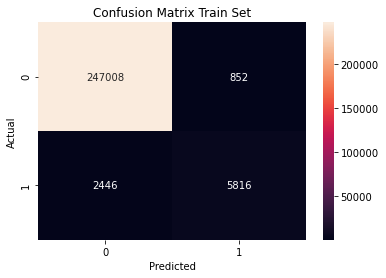

In [49]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

Confusion matrix on test set : 
[[27423   117]
 [  305   613]]



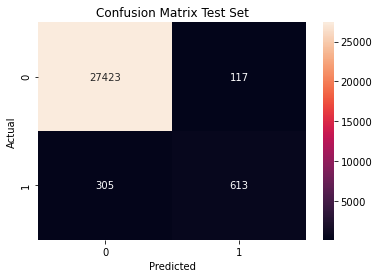

In [50]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [51]:
# Store result
decisionTree_train = f1_score(Y_train, Y_train_pred)
print(decisionTree_train)
decisionTree_test = f1_score(Y_test, Y_test_pred)
print(decisionTree_test)

0.7791024782317482
0.7439320388349515


#### With hyperparameter optimization

In [52]:
# Separate target variable Y from features X

features_list = ['total_pages_visited','age','country','new_user']
numeric_indices = [0,1]
categorical_indices = [2,3]
target_variable = 'converted'

print("Separating labels from features...")
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]
print("...Done.")
print()
print('Explanatory variables : ', X.columns)
print()
print(X.head())
print()
print(Y.head())
print()

Separating labels from features...
...Done.

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user'], dtype='object')

   total_pages_visited  age  country  new_user
0                    2   22    China         1
1                    3   21       UK         1
2                   14   20  Germany         0
3                    3   23       US         1
4                    3   28       US         1

0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64



In [53]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [54]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print()
print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done

[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
[[14 24 'China' 1]
 [5 35 'US' 0]]

[0 0 0 0 0]
[0 0]


In [55]:
numeric_features = [0,1]
numeric_transformer = StandardScaler()

In [56]:
categorical_features = [2,3]
categorical_transformer = OneHotEncoder(drop='first')

In [57]:
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [58]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor3.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor3.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[[14 24 'China' 1]
 [5 35 'US' 0]
 [4 29 'US' 0]
 [8 31 'China' 1]
 [2 28 'US' 1]]
...Done.
[[ 2.73051047 -0.79365434  0.          0.          0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1. 

In [59]:
# Perform grid search
print("Grid search...")
classifier4 = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier4, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8}
Best validation accuracy :  0.9854561498036092


In [60]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [61]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [62]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7615925058548009
f1-score on test set :  0.7486437613019893


Confusion matrix on train set : 
[[246868    992]
 [  2571   5691]]



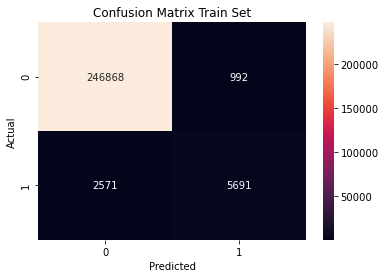

In [63]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

Confusion matrix on test set : 
[[27420   120]
 [  297   621]]



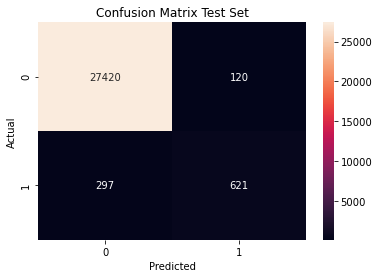

In [64]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [65]:
# Store result
decisionTree2_train = f1_score(Y_train, Y_train_pred)
print(decisionTree2_train)
decisionTree2_test = f1_score(Y_test, Y_test_pred)
print(decisionTree2_test)

0.7615925058548009
0.7486437613019893


## Part 5 : Data preprocessing and Random Forest

Now, i refine the model with a Random Forest to see if i can find a better model.

#### Without hyperparameter optimization

In [66]:
# Separate target variable Y from features X

features_list = ['total_pages_visited','age','country','new_user']
numeric_indices = [0,1]
categorical_indices = [2,3]
target_variable = 'converted'

print("Separating labels from features...")
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]
print("...Done.")
print()
print('Explanatory variables : ', X.columns)
print()
print(X.head())
print()
print(Y.head())
print()

Separating labels from features...
...Done.

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user'], dtype='object')

   total_pages_visited  age  country  new_user
0                    2   22    China         1
1                    3   21       UK         1
2                   14   20  Germany         0
3                    3   23       US         1
4                    3   28       US         1

0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64



In [67]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [68]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print()
print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done

[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
[[14 24 'China' 1]
 [5 35 'US' 0]]

[0 0 0 0 0]
[0 0]


In [69]:
numeric_features = [0,1]
numeric_transformer = StandardScaler()

In [70]:
categorical_features = [2,3]
categorical_transformer = OneHotEncoder(drop='first')

In [71]:
preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [72]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor4.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor4.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[[14 24 'China' 1]
 [5 35 'US' 0]
 [4 29 'US' 0]
 [8 31 'China' 1]
 [2 28 'US' 1]]
...Done.
[[ 2.73051047 -0.79365434  0.          0.          0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1. 

In [73]:
# Train model
print("Train model...")
classifier5 = RandomForestClassifier(n_estimators=50) 
classifier5.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [74]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier5.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [75]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier5.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [76]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7807081644854845
f1-score on test set :  0.7453341360626128


Confusion matrix on train set : 
[[246945    915]
 [  2386   5876]]



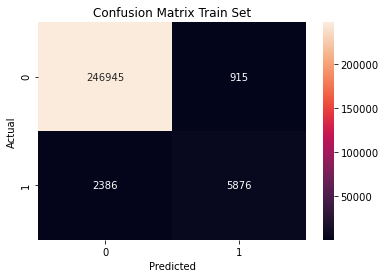

In [77]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

Confusion matrix on test set : 
[[27416   124]
 [  299   619]]



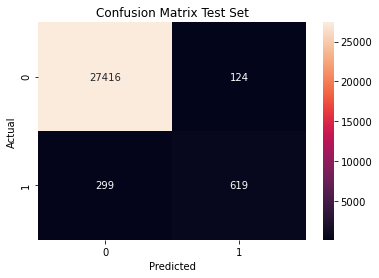

In [78]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [79]:
# Store result
randomForest_train = f1_score(Y_train, Y_train_pred)
print(randomForest_train)
randomForest_test = f1_score(Y_test, Y_test_pred)
print(randomForest_test)

0.7807081644854845
0.7453341360626128


#### With hyperparameter optimization

In [80]:
# Separate target variable Y from features X

features_list = ['total_pages_visited','age','country','new_user']
numeric_indices = [0,1]
categorical_indices = [2,3]
target_variable = 'converted'

print("Separating labels from features...")
X = df.loc[:, features_list]
Y = df.loc[:, target_variable]
print("...Done.")
print()
print('Explanatory variables : ', X.columns)
print()
print(X.head())
print()
print(Y.head())
print()

Separating labels from features...
...Done.

Explanatory variables :  Index(['total_pages_visited', 'age', 'country', 'new_user'], dtype='object')

   total_pages_visited  age  country  new_user
0                    2   22    China         1
1                    3   21       UK         1
2                   14   20  Germany         0
3                    3   23       US         1
4                    3   28       US         1

0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64



In [81]:
# Divide dataset Train set & Test set 

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [82]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")
print()
print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done

[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
[[14 24 'China' 1]
 [5 35 'US' 0]]

[0 0 0 0 0]
[0 0]


In [83]:
numeric_features = [0,1]
numeric_transformer = StandardScaler()

In [84]:
categorical_features = [2,3]
categorical_transformer = OneHotEncoder(drop='first')

In [85]:
preprocessor5 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [86]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor5.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor5.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[2 23 'China' 0]
 [2 28 'China' 0]
 [7 30 'China' 1]
 [3 37 'UK' 1]
 [8 31 'US' 1]]
...Done.
[[-0.85939501 -0.91458053  0.          0.          0.          0.        ]
 [-0.85939501 -0.30994956  0.          0.          0.          0.        ]
 [ 0.63639894 -0.06809718  0.          0.          0.          1.        ]
 [-0.56023622  0.77838618  0.          1.          0.          1.        ]
 [ 0.93555773  0.05282902  0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[[14 24 'China' 1]
 [5 35 'US' 0]
 [4 29 'US' 0]
 [8 31 'China' 1]
 [2 28 'US' 1]]
...Done.
[[ 2.73051047 -0.79365434  0.          0.          0.          1.        ]
 [ 0.03808136  0.53653379  0.          0.          1.          0.        ]
 [-0.26107743 -0.18902337  0.          0.          1.          0.        ]
 [ 0.93555773  0.05282902  0.          0.          0.          1.        ]
 [-0.85939501 -0.30994956  0.          0.          1. 

In [87]:
# Perform grid search
print("Grid search...")
classifier6 = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [40,50,60]
}
gridsearch2 = GridSearchCV(classifier6, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch2.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch2.best_params_)
print("Best validation accuracy : ", gridsearch2.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}
Best validation accuracy :  0.9859715291931189


In [88]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch2.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [89]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch2.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [90]:
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7667024416420714
f1-score on test set :  0.75181598062954


Confusion matrix on train set : 
[[246929    931]
 [  2547   5715]]



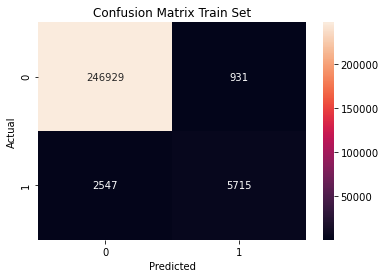

In [91]:
# Check more performance metrics to better understand what your model is doing
#Confusion matrix on train set
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
actual_data = Y_train
predicted_data = Y_train_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Train Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

Confusion matrix on test set : 
[[27427   113]
 [  297   621]]



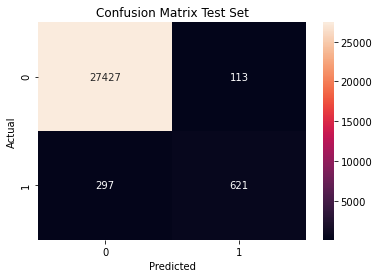

In [92]:
# Confusion matrix on test set 
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

actual_data = Y_test
predicted_data = Y_test_pred
cm = confusion_matrix(actual_data, predicted_data)
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title('Confusion Matrix Test Set');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.show()

In [93]:
# Store result
randomForest2_train = f1_score(Y_train, Y_train_pred)
print(randomForest2_train)
randomForest2_test = f1_score(Y_test, Y_test_pred)
print(randomForest2_test)

0.7667024416420714
0.75181598062954


## Part 6 : Feature importance ranking

In [94]:
classifier2.coef_

array([[ 2.54779374, -0.60218803,  3.62873721,  3.42876586,  3.07144722,
        -1.71893561]])

Feature: 0, Score: 2.54779
Feature: 1, Score: -0.60219
Feature: 2, Score: 3.62874
Feature: 3, Score: 3.42877
Feature: 4, Score: 3.07145
Feature: 5, Score: -1.71894


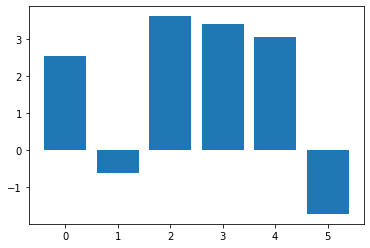

In [96]:
# get importance
importance = classifier2.coef_[0]
# summarize feature importance
for i,j in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,j))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The country is the most important features then the number of pages visited.

## Part 7 : Submission to the leaderboard 

Summary results before submitting one to the leaderboard

In [97]:
score = pd.DataFrame({'Baseline': [0.697,0.677], 'Multivariate_LR': [0.763,0.758], 
                      'DecisionTree': [0.779,0.744], 'DecisionTree2': [0.761,0.749],
                      'RandomForest': [0.781,0.745], 'RandomForest2': [0.767,0.752]},
                      index = ['Train', 'Test'])
score

,Baseline,Multivariate_LR,DecisionTree,DecisionTree2,RandomForest,RandomForest2
Train,0.697,0.763,0.779,0.761,0.781,0.767
Test,0.677,0.758,0.744,0.749,0.745,0.752


The results of the different models are quite  similar (except for the baseline model).

To choose the model to submit to the leaderboard, I decided to take the one that made the least prediction errors based on the differents matrix confusions on test sets.

It is therefore the multivariate logistic regression model that I have chosen. It is also the one that gets the best score on the test set even if this is a model with a slight overfitting.


#### Submission to the leaderboard

In [98]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier2.fit(X,Y)

LogisticRegression()

In [99]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

features_list = ['total_pages_visited','age','country','new_user']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16 28 'UK' 0]
 [5 22 'UK' 1]
 [1 32 'China' 1]
 [6 32 'US' 1]
 [3 25 'China' 0]]


In [100]:
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32882805 -0.30994956  0.          1.          0.          0.        ]
 [ 0.03808136 -1.03550673  0.          1.          0.          1.        ]
 [-1.1585538   0.17375521  0.          0.          0.          1.        ]
 [ 0.33724015  0.17375521  0.          0.          1.          1.        ]
 [-0.56023622 -0.67272814  0.          0.          0.          0.        ]]


In [101]:
data = {
    'converted': classifier2.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_Charlotte-model.csv', index=False)

## Part 8 : Conclusion

The models tested give equivalent results.

The best seems to be the multivariate logistic regression.

It would seem from these model that the most important factor is the country then the number of pages visited by users.

My recommendation is to enrich the existing database for the target column to balance the data.

It would be interesting to study the pages visited by users according to their country to determine if a particular page or more affect the newsletter's conversion rate
